# SocialBuzz Sentiment NLP
By Jonathan Nunez

# Business Understanding

WIP

Social media has become prevalant in day to day life, through daily posting of their daily lives, thoughts and opinions, as well as keeping other informed on current events. In this project the goal is to develope and train an NLP model to detect and classify the sentiment behind the post. 

# Data Understanding

WIP

The data used for this project is the [SocialBuzz Sentiment Analytics](https://www.kaggle.com/datasets/eshummalik/socialbuzz-sentiment-analytics) dataset found in [Kaggle](https://www.kaggle.com/datasets). This dataset is comprised of a little over 700 social media post, containing hastags, time posted, number of times a post was liked or retweeded, as well as the sentiment behind the post. 

In [1]:
# Importing tools and modules
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [2]:
data = pd.read_csv('data/sentiment.csv')

df = data.copy()

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    732 non-null    int64  
 1   Unnamed: 0.1  732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [5]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


In [6]:
# Dropping 'Unamed' columns
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

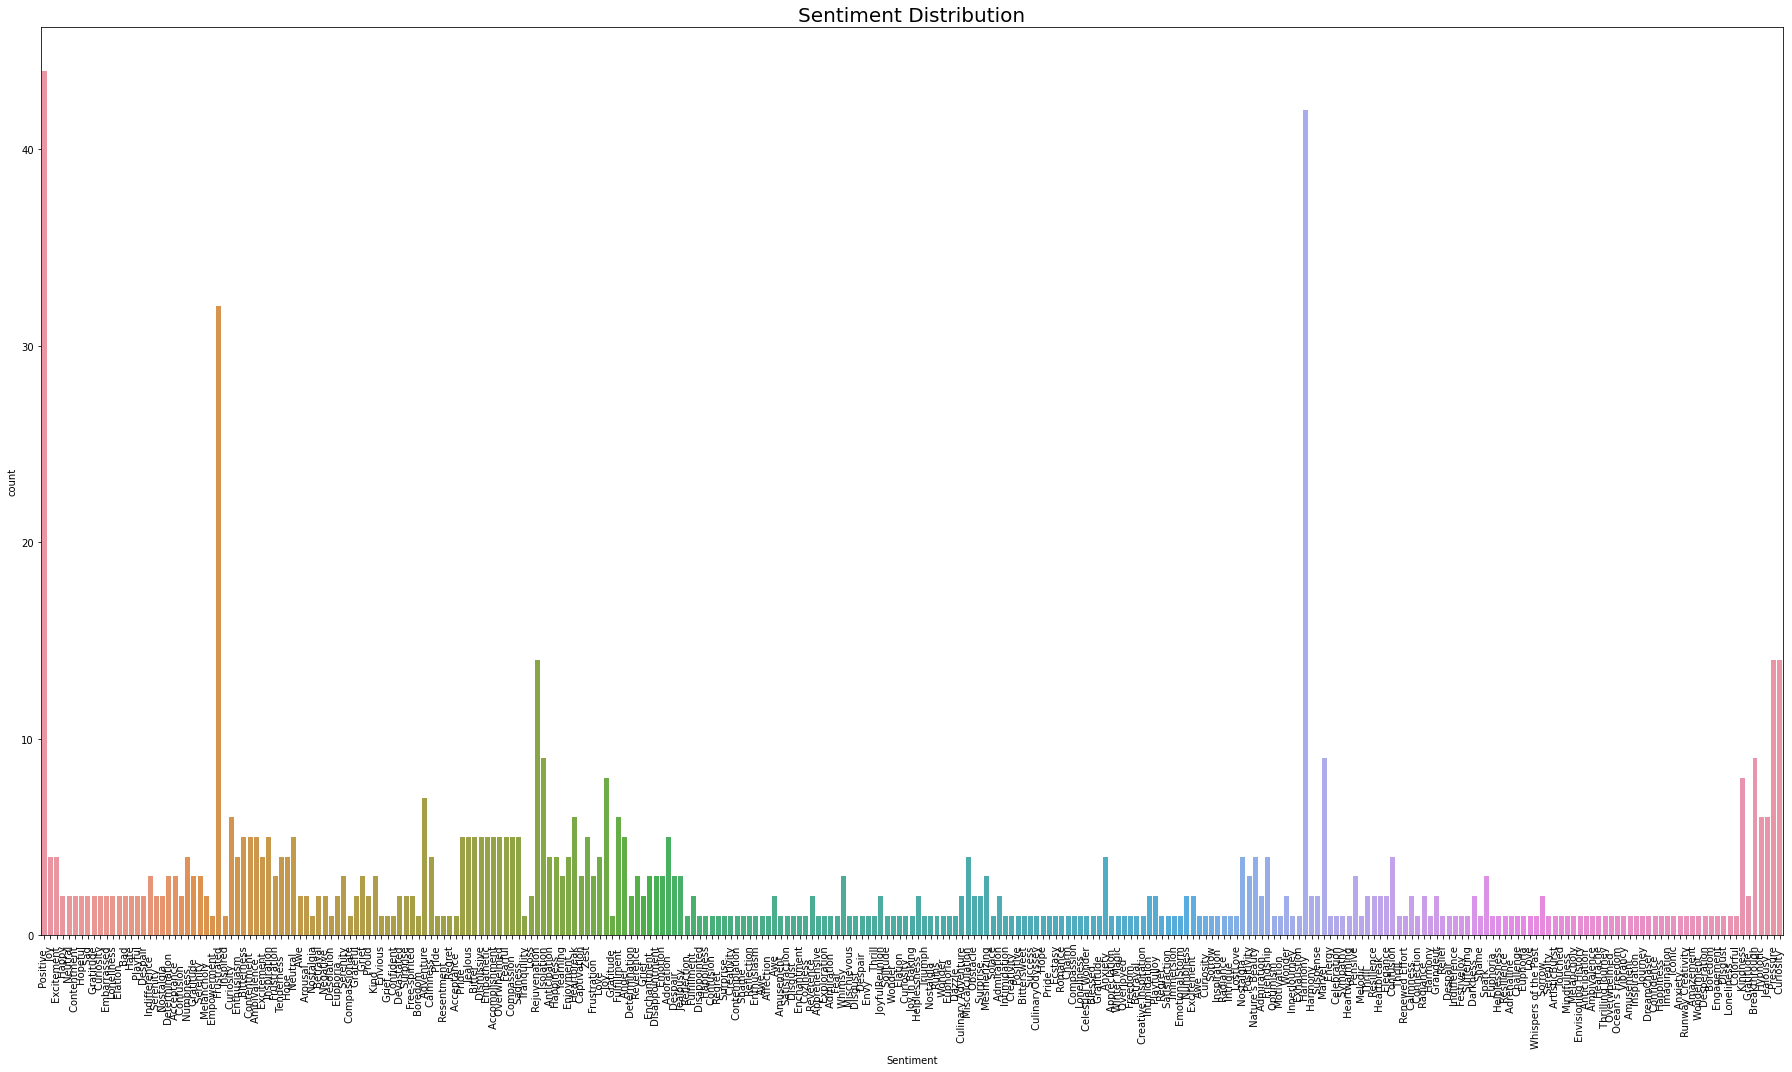

In [7]:
fig, ax = plt.subplots(figsize=(25, 15))
sn.countplot(data=df, x=df['Sentiment'])

ax.set_title('Sentiment Distribution', fontsize=20)
ax.set_xticklabels(df['Sentiment'].value_counts().index, rotation=90)
plt.tight_layout();

# Data Preparation

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df['sentiment'].value_counts()

 Positive         44
 Joy              42
 Excitement       32
 Happy            14
 Neutral          14
                  ..
 Breakthrough      1
 Hypnotic          1
 Jealousy          1
 Pressure          1
 Curiosity         1
Name: sentiment, Length: 279, dtype: int64

In [10]:
# Function to lowercase text
def lower_and_clean(df, columns):
    """
    This function takes in a df as well as a list of column names 
    and lowercases the string text
    
    Arg:
    df: Dataframe
    columns: A list of column names to lowercase
    """
    for col in columns:
        df[col] = df[col].str.lower()
    return df

In [11]:
to_clean = ['text', 'sentiment']

In [12]:
lower_and_clean(df, to_clean)

df.head()

,text,sentiment,timestamp,user,platform,hashtags,retweets,likes,country,year,month,day,hour
0,enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [13]:
df['sentiment'].unique()

array([' positive  ', ' negative  ', ' neutral   ', ' anger        ',
       ' fear         ', ' sadness      ', ' disgust      ',
       ' happiness    ', ' joy          ', ' love         ',
       ' amusement    ', ' enjoyment    ', ' admiration   ',
       ' affection    ', ' awe          ', ' disappointed ',
       ' surprise     ', ' acceptance   ', ' adoration    ',
       ' anticipation ', ' bitter       ', ' calmness     ',
       ' confusion    ', ' excitement   ', ' kind         ',
       ' pride        ', ' shame        ', ' confusion ', ' excitement ',
       ' shame ', ' elation       ', ' euphoria      ', ' contentment   ',
       ' serenity      ', ' gratitude     ', ' hope          ',
       ' empowerment   ', ' compassion    ', ' tenderness    ',
       ' arousal       ', ' enthusiasm    ', ' fulfillment  ',
       ' reverence     ', ' compassion', ' fulfillment   ', ' reverence ',
       ' elation   ', ' despair         ', ' grief           ',
       ' loneliness     

In [ ]:
postive = ['positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration','affection', 'awe', 'surprise', 
           'adoration', 'anticipation', 'excitement', 'kind', 'pride', 'elation', 'euphoria', 'contentment', 'gratitude', 
           'hope', 'tenderness']

negative = ['negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'bitter', 'shame', ]

neutral = ['neutral', 'acceptance', 'calmness', 'confusion', 'serenity', 'empowerment', 'compassion']


In [14]:
df[df['sentiment'].str.contains('arousal')]

,text,sentiment,timestamp,user,platform,hashtags,retweets,likes,country,year,month,day,hour
118,arousal of excitement as i await a special an...,arousal,2017-10-30 11:30:00,ExcitementFan,Twitter,#Arousal #Excitement,20.0,40.0,Australia,2017,10,30,11
131,arousal of excitement for an upcoming adventu...,arousal,2017-04-30 11:30:00,AdventureAwaits,Instagram,#Arousal #AdventureTime,20.0,40.0,Australia,2017,4,30,11
145,arousal of excitement before a much-awaited t...,arousal,2018-03-10 09:45:00,TravelExcitement,Twitter,#Arousal #TravelAdventure,20.0,40.0,India,2018,3,10,9
158,arousal of excitement for an upcoming festiva...,arousal,2017-09-25 11:30:00,FestivalFan,Instagram,#Arousal #FestivalExcitement,20.0,40.0,UK,2017,9,25,11


# Modeling

In [12]:
X = df[['text']]
y = df['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [14]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Evaluation

## Recomendations

## Next Steps

# Conclusion